# VAE on ModelNet for scene completion

## RecVis Final Project, MVA 2024-2025

## Model inspired from the class Introduction to Probabilistic and Graphical Models, by P Latouche, PA Mattei, R Khallaf.

Imports and setup

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

import torch
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
import pickle
from sklearn.decomposition import PCA

In [2]:
rng = np.random.default_rng(seed=42)

In [3]:
sys.path.append('/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/')

from libs import dataset

In [4]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

if use_cuda:
    print(f"Using GPU") 
else:
    print(f"Using CPU")

Using GPU


Import dataset and form dataloaders for Data Analysis

In [5]:
# uses datasets and Dataset class from https://github.com/antao97/PointCloudDatasets/

# parameters :
# root : root directory, must contain file dataset_name + '_hdf5_2048
# dataset_name : modelnet10 par défaut, sinon modelnet40
# class_choice : permet de ne sélectionner qu'une classe
# split : 'train' par défaut. valeurs possibles = 'test', 'trainval', 'all', etc.
# possibilité de data augmentation également

modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

In [6]:
print(f"ModelNet10 dataset has {len(modelnet10)} elements")
print(f"ModelNet40 dataset has {len(modelnet40)} elements")

ModelNet10 dataset has 4899 elements
ModelNet40 dataset has 12311 elements


In [7]:
mn10_loader = DataLoader(
    modelnet10,
    batch_size=4,
    shuffle=True
    )

mn10_iter = iter(mn10_loader)

In [8]:
# outputs : normalized tensors of 2048 points (x,y,z)

point_set, label, name, file = next(mn10_iter)

print(f"point set = {point_set.shape}")
print(f"label = {label}")
print(f"name = {name}")
print(f"file = {file}")

point set = torch.Size([4, 2048, 3])
label = tensor([[8],
        [8],
        [8],
        [0]])
name = ('table', 'table', 'table', 'bathtub')
file = ('table/table_0077.ply', 'table/table_0279.ply', 'table/table_0095.ply', 'bathtub/bathtub_0123.ply')


Some visualisation for Data Analysis

In [9]:
def display_points_list(points_list, name="inconnu"):
    """Display points list

    Args:
        points_list (torch.tensor): torch.tensor shape 2048 x 3
    """
    
    data = points_list.numpy().reshape(2048,3)
    df = pd.DataFrame(data=data, columns=['X','Y','Z'])
    fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.2, symbol_sequence=['cross'], title=f"{name}")
    
    return fig

In [10]:
batch_size = 2

for tensor_pc in range(2):
    batch_ps, batch_labels, batch_names, _ = next(mn10_iter)
    for i in range(batch_size):
        ps = batch_ps[i]
        label = batch_labels[i]
        name = batch_names[i]
        fig = display_points_list(ps, name)
        fig.show()

### The ModelNet datasets handle 3D point clouds as lists of 2048 points (x,y,z).

### We will use a tensor view of those points clouds, ie Tensors 3D of size NX x NY x NZ, with each element being 0 or 1. In pratice, NX=NY=NZ=2^m with m=4,5 or 6.

# Hyperparameters

In [11]:
# size of the cube
NX = 32
NY = 32
NZ = 32
p = NX*NY*NZ

### Data Conversion utility functions

Class to navigate between point clouds as list of (x,y,z) and tensor (NX,NY,NZ) of 0's and 1's

In [12]:

class PointCloud():
    """Utility class to handle point cloud
    Manages two views :
    - a list of 2048 points (x,y,z) normalized within [-1,1]^3, as out of the ModelNet datasets
    - a 3D tensor of NX x NY x NZ shape
    """
    
    def __init__(self, nx=NX, ny=NY, nz=NY, from_list=None, from_3d_tensor=None):
        self.nx = nx
        self.ny = ny
        self.nz = nz
        assert ((from_list != None) or (from_3d_tensor != None)), "need to choose between points list and 3d tensor"
        if from_list != None:
            # input is a 3D tensor shape 2048 x 3 : list of points
            self.points_list = from_list
            self.tensor_3d = None
        else:
            # input is a 3D tensor (nx x ny x nz) of 0 or 1s
            self.tensor_3d = from_3d_tensor
            self.points_list = None
        self.dx = 2 / self.nx
        self.dy = 2 / self.ny
        self.dz = 2 / self.nz
    
    def set_points_list(self):
        # assumes that self.tensor_3d exists
        # create the points_list view
        self.points_list = torch.zeros((2048,3))
        index = 0
        for i in range(self.nx):
            cx = -1 + (2*i+1)*self.dx/2
            for j in range(self.ny):
                cy = -1 + (2*j+1)*self.dy/2
                for k in range(self.nz):
                    cz = -1 + (2*k+1)*self.dy/2
                    n_points = self.tensor_3d[i,j,k]
                    if n_points >= 1:
                        for l in range(n_points):
                            # add points of ccorodinates (cx,cy,cz) to the points list
                            self.points_list[index,0] = cx
                            self.points_list[index,1] = cy
                            self.points_list[index,2] = cz
                            index += 1
    
    def set_3d_tensor(self):
        # assumes that self.points_list exists
        # create the 3d_tensor view
        self.tensor_3d = torch.zeros((self.nx, self.ny, self.nz))
        for i in range(self.points_list.shape[0]):
            # get next point in the list
            x = self.points_list[i,0]
            y = self.points_list[i,1]
            z = self.points_list[i,2]
            # get coordinates in the 3D tensor
            # ix = int(np.floor((x+1)/self.dx)) ... not cuda type error ...
            # iy = int(np.floor((y+1)/self.dy))
            # iz = int(np.floor((z+1)/self.dz))
            ix = int(torch.floor((x+1)/self.dx).item())
            if ix < 0: ix=0
            if ix >= self.nx: ix = self.nx-1
            
            iy = int(torch.floor((y+1)/self.dy).item())
            if iy < 0: iy=0
            if iy >= self.ny: iy = self.ny-1
            
            iz = int(torch.floor((z+1)/self.dz).item())
            if iz < 0: iz=0
            if iz >= self.nz: iz = self.nz-1
            
            self.tensor_3d[ix,iy,iz] = 1
    
    def get_points_list(self):
        return self.points_list
    
    def get_3d_tensor(self):
        return self.tensor_3d
    
    def __repr__(self):
        msg = f"Point Cloud instance\n"
        msg += f"Points list view : {self.points_list}\n"
        msg += f"3D tensor view : {self.tensor_3d}\n"
        return msg

Example use of the class PointCloud

In [13]:
ps.shape

# instantiate a PointCloud object from a list 2048 x (x,y,z) data point
pc = PointCloud(from_list=ps)

In [14]:
pc.get_points_list()

tensor([[ 0.2354, -0.3991,  0.1364],
        [-0.4762,  0.4675, -0.2103],
        [-0.4435, -0.5563, -0.6310],
        ...,
        [ 0.4382, -0.5938, -0.2378],
        [ 0.2089,  0.2086,  0.2491],
        [ 0.2947, -0.3541, -0.3558]])

In [15]:
display_points_list(pc.get_points_list(), "quelconque")

In [16]:
# get the view as 3D tensor : (NX,NY,NZ) x (0 or 1)
pc.set_3d_tensor()

In [17]:
def display_3d_tensor(tensor_3d, name="quelconque"):
    """Display point cloud with tensor 3d (NX x NY x NZ) as input

    Args:
        tensor_3d (tensor): Torch tensor shape NX x NY x NZ
        name (str, optional): string à afficher comme titre. Defaults to "inconnu".
    """
    
    xs = []
    ys = []
    zs = []
    for i in range(NX):
        for j in range(NY):
            for k in range(NZ):
                n = tensor_3d[i,j,k]
                if n >= 1:
                    xs.append(i)
                    ys.append(j)
                    zs.append(k)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs,ys,zs,marker='.')
    ax.set_xlim(left=0, right=NX)
    ax.set_ylim(bottom=0, top=NY)
    ax.set_zlim(bottom=0, top=NZ)
    ax.set_title(name)
    
    return fig

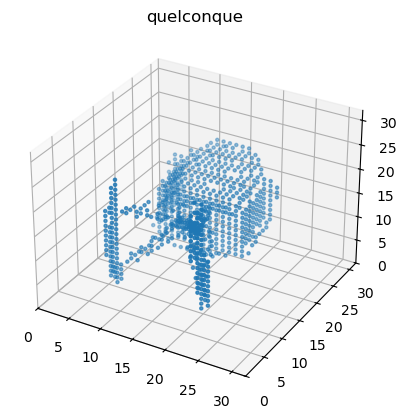

In [18]:
# display the same data point from the tensor view
fig = display_3d_tensor(pc.get_3d_tensor())

### Converting the datasets from list points to tensors 3D

For the VAE study, it is convenient to "convert" the ModelNet datasets from the form 2048 x (x,y,z) to the form (NX,NY,NZ) x (0 or 1). The conversion is too heavy to do it on the fly in the training loop, so we'll run the transforms on the whole datasets up front.

In [19]:
def convert_batch_to_tensors_3d(batch_points_list):
    """Converts a tensor (batch_size x (2048 x 3)) points cloud
    in a batch (batch_size x (NX,NY,NZ))

    Args:
        batch_points_list (torch.tensor): batch_szie tensors of shape (2048 x 3)
    Returns:
        batch_size 3D_tensors of shape (NX,NY,NZ) of 0s and 1s
    """
    
    batch_dim = batch_points_list.shape[0]
    batch_tensors_3d = torch.zeros((batch_dim,NX,NY,NZ))
    for i in range(batch_dim):
        point_list = batch_points_list[i]
        pc = PointCloud(from_list = point_list, nx=NX, ny=NY, nz=NZ)
        pc.set_3d_tensor()
        tensor_3d = pc.get_3d_tensor()
        batch_tensors_3d[i] = tensor_3d
        
    return batch_tensors_3d

In [20]:
mn10_iter = iter(mn10_loader)

for tensor_pc in range(1):
    # outputs :
    # batch_ps = batch_size x 2048 x 3 (torch.tensor)
    # batch_labels = batch_size x 1 (troche.tensor)
    batch_ps, batch_labels, _, _ = next(mn10_iter)
    print(f"batch_ps = {batch_ps.shape}")
    
    batch_tensors_3d = convert_batch_to_tensors_3d(batch_ps)
    print(f"batch converti tensors_3d = {batch_tensors_3d.shape}")

batch_ps = torch.Size([4, 2048, 3])
batch converti tensors_3d = torch.Size([4, 32, 32, 32])


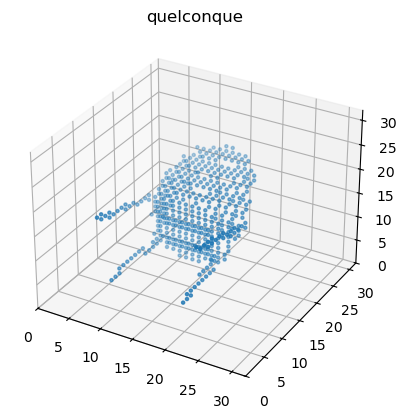

In [21]:
# check the transform function
i = 2

fig = display_3d_tensor(batch_tensors_3d[i])

In [22]:
fig = display_points_list(batch_ps[i])
fig.show()

In [23]:
# load the original format datasets : points list (2048 x 3)
modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

Convert ModelNet10 from 2048 x (x,y,z) to ModelNet_converted as (NX,NY,NZ) x (0 or 1)

In [24]:
# Converting ModelNet10 to ModelNet10_converted : tensors 3D : (NX,NY,NZ) of 0s and 1s

mn10_loader = DataLoader(
    modelnet10,
    batch_size=256,
    shuffle=True
    )

# mn10_iter = iter(mn10_loader)
l = len(mn10_loader)
modelnet10_converted_dataset = None

# UNCOMMENT TO RUN THE CONVERSION

# for i, (point_set, label, name, file) in enumerate(mn10_loader):
#     point_set_to_tensors_3d = convert_batch_to_tensors_3d(point_set)
#     if modelnet10_converted_dataset is None:
#         modelnet10_converted_dataset = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
#     else:
#         addition = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
#         modelnet10_converted_dataset = torch.utils.data.ConcatDataset([modelnet10_converted_dataset, addition])
#         print(f"Conversion ModelNet10 Dataset - Etape {i+1}/{l} - longueur dataset assemblé = {len(modelnet10_converted_dataset)}", end="\r")

In [25]:
# increase recursion limit for pickle to work
max_rec = 10000
sys.setrecursionlimit(max_rec)
# print (sys.getrecursionlimit())

In [26]:
# saving converted mn10
conversions_dir = '/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/converted_datasets'

# UNCOMMENT TO SAVE

# mn10_converted_ds_filepath = conversions_dir + '/modelnet10_converted_dataset_NX.pkl'
# with open(mn10_converted_ds_filepath, "wb") as f:
#     pickle.dump(modelnet10_converted_dataset, f)

Convert ModelNet40 from 2048 x (x,y,z) to ModelNet_converted as (NX,NY,NZ) x (0 or 1)

In [27]:
# Converting ModelNet40 to ModelNet40_converted : tensors 3D : (NX,NY,NZ) of 0s and 1s

mn40_loader = DataLoader(
    modelnet40,
    batch_size=256,
    shuffle=True
    )

l = len(mn40_loader)
modelnet40_converted_dataset= None

# UNCOMMENT TO RUN THE CONVERSION

# for i, (point_set, label, name, file) in enumerate(mn40_loader):
#     point_set_to_tensors_3d = convert_batch_to_tensors_3d(point_set)
#     if modelnet40_converted_dataset is None:
#         modelnet40_converted_dataset = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
#     else:
#         addition = torch.utils.data.TensorDataset(point_set_to_tensors_3d, label)
#         modelnet40_converted_dataset = torch.utils.data.ConcatDataset([modelnet40_converted_dataset, addition])
#         print(f"Conversion ModelNet40 - Etape {i+1}/{l} - longueur dataset assemblé = {len(modelnet40_converted_dataset)}", end="\r")

In [28]:
# saving converted mn40
mn40_converted_ds_filepath = conversions_dir + '/modelnet40_converted_dataset_NX.pkl'

# UNCOMMENT TO SAVE

# with open(mn40_converted_ds_filepath, "wb") as f:
#     pickle.dump(modelnet40_converted_dataset, f)

# Model

Data load

In [29]:
# # datasets
# modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
# modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

# print(f"ModelNet10 dataset has {len(modelnet10)} elements")
# print(f"ModelNet40 dataset has {len(modelnet40)} elements")

In [30]:
batch_size = 512
conversions_dir = '/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/converted_datasets'

In [31]:
# DataLoader for ModelNet10 converti en Tensors 3D

mn10_converted_ds_filepath = conversions_dir + '/modelnet10_converted_dataset_32.pkl'
with open(mn10_converted_ds_filepath, "rb") as f:
    modelnet10_converted = pickle.load(f)
    
mn10_converted_loader = DataLoader(
    modelnet10_converted,
    batch_size=batch_size,
    shuffle=True
)

print(f"Converted MN10 dataloader = {mn10_converted_loader}")

Converted MN10 dataloader = <torch.utils.data.dataloader.DataLoader object at 0x7927481eb580>


In [32]:
# DataLoader for ModelNet40 converti en Tensors 3D

mn40_converted_ds_filepath = conversions_dir + '/modelnet40_converted_dataset_32.pkl'
with open(mn40_converted_ds_filepath, "rb") as f:
    modelnet40_converted = pickle.load(f)

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

print(f"Converted MN40 dataloader = {mn40_converted_loader}")

Converted MN40 dataloader = <torch.utils.data.dataloader.DataLoader object at 0x79273dfdc640>


# Setting up the dimension of the latent space - important hyperparameter !

In [33]:
# Latent space dimension
latent_dim = 128

### Graphical Model

We will use a deep latent variable model with a Gaussian prior and a Bernoulli observation model. 

A point cloud $c_i$ is a set of voxels $x_{j,k,l} \in [0,1], j \in [0, NX-1], k \in [0, NY-1], l \in [0, NZ-1]$.

This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{c}_1,...,\mathbf{c}_n) = \prod_{i=1}^n p_{\boldsymbol{\theta}}(\mathbf{c}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{c}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_{j,k,l}|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)) = \prod_{j,k,l=1}^{NX, NY, NZ} \mathcal{B} (\mathbf{x}_{ijk}|[\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)]_{i,j,k}),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow {[0,1]}^p$ is the decoder parametrised by a deep neural net. This neural net will be defined as a Pytorch model.

Prior : the prior of the latent variable $z$ is simply a normalized Gaussian of dimension latent_dim

In [34]:
p_z = td.Independent(
    td.Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim)),
    reinterpreted_batch_ndims=1
    )

In [35]:
# draw 2 samples of dimension <latent_dim>
#
# .rsample() uses the reparametrization trick (see Kingma 2014)
#

p_z.rsample((2,))

tensor([[ 1.2528e-01,  1.7357e+00,  1.4001e-01,  7.4752e-02,  8.5209e-01,
          8.6822e-03,  1.2493e+00, -6.2653e-01,  1.1640e+00, -5.6598e-02,
         -5.9548e-02,  6.5818e-01,  6.7754e-01,  1.2003e+00,  5.4143e-01,
         -6.0756e-01, -4.2204e-01, -2.6157e-01, -6.0750e-01, -1.2044e+00,
          3.4135e-01, -5.4644e-01, -7.7654e-02,  1.5049e-01, -2.0865e-02,
          2.4073e+00, -1.7981e-01, -1.6782e+00, -8.0210e-01,  7.8261e-01,
          2.4001e+00,  2.3016e-01, -2.4093e-01, -1.1666e+00,  1.0578e+00,
          8.4223e-01,  3.3666e-01,  5.5491e-01, -4.6185e-02, -2.0189e+00,
          5.4572e-01,  3.0727e-01,  3.6450e-03, -3.0893e-01, -8.9193e-01,
         -2.1083e-01,  3.3857e-01, -9.8641e-01, -1.3184e+00, -3.3507e-01,
          8.9728e-01,  3.9700e-01,  8.1768e-01, -6.3500e-02, -9.7471e-01,
          8.2189e-01, -2.5929e+00, -6.6585e-01,  1.2420e-02,  9.7013e-01,
         -4.8037e-02,  1.3994e+00, -5.0234e-01, -2.3839e+00, -1.4885e+00,
         -1.1925e-01, -3.4396e-01,  7.

### Encoder : we use a vanilla 3D encoder with a couple of Convolution 3D layers

In [36]:
# encoder takes as input a 3D tensor [NX,NY,NZ] of 0s and 1s

# Dummy encoder to validate pipeline
# class Encoder(nn.Module):
#         def __init__(self):
#                 super(Encoder, self).__init__()
#                 self.fc1 = nn.Linear(p, num_hidden)
#                 self.fc2 = nn.Linear(num_hidden, num_hidden)
#                 self.fc3 = nn.Linear(num_hidden, latent_dim*2)
                
#         def forward(self, inputs):
#                 # input is batch_size x (NX,NY,NZ)
#                 x = inputs.view(inputs.size(0), -1)
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc2(x))
#                 x = F.relu(self.fc3(x))
#                 # output is batch_size x (latent_dim*2)
#                 return x
        

# CNN3D Encoder

class Encoder3D(nn.Module):
        def __init__(self):
                super(Encoder3D, self).__init__()
                self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
                self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
                self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
                n = int(NX*NY*NZ/8)
                self.fc = nn.Linear(n, latent_dim*2)
                
        def forward(self,inputs):
                # input is batch_size x (NX,NY,NZ)
                s = inputs.shape
                x = inputs.view(s[0], 1, s[1], s[2], s[3]) # out = batch x 1 x NX x NY x NZ
                x = self.conv1(x) # out : batch x 16 x nx x ny x nz
                x = F.relu(nn.AvgPool3d(2)(x)) # out ; batch x 16 x nx/2 x ny/2 x nz/2
                x = self.conv2(x) # out : batch x 32 x nx/2 x ny/2 x nz/2
                x = F.relu(nn.AvgPool3d(2)(x)) # out : batch x 32 x nx/4 x ny/4 x nz/4
                x = self.conv3(x) # out : batch x 64 x nx/4 x ny/4 x nz/4
                x = F.relu(nn.AvgPool3d(2)(x)) # out : batch x 64 x nx/8 x ny/8 x nz/8
                x = x.view(s[0], -1) # out : batch x (nx x ny x nz)/8
                x = self.fc(x) # out : batch x latent_dim * 2
                return x
        
encoder = Encoder3D()

In [37]:
# checking dimensions...
# 
batch_example_size = 8

x = torch.randn((batch_example_size,NX,NY,NZ))
print(f"input = {x.shape}")
print(f"output = {encoder(x).shape}")

input = torch.Size([8, 32, 32, 32])
output = torch.Size([8, 256])


Testing the pipeline !

In [38]:
# get data
mn40_iter = iter(mn40_converted_loader)
batch_ps, batch_label = next(mn40_iter)
print(f"batch = {batch_ps.shape}")

# encode
encoded_batch = encoder(batch_ps)
print(f"encoded batch = {encoded_batch.shape}")

# get latent variable parameters
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
print(f"mu = {mu_q.shape}")
print(f"sigma_q = {sigma_q.shape}")

# instantiate posterior distribution z|x
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior = {q_zgivenx}")

batch = torch.Size([512, 32, 32, 32])
encoded batch = torch.Size([512, 256])
mu = torch.Size([512, 128])
sigma_q = torch.Size([512, 128])
posterior = Independent(Normal(loc: torch.Size([512, 128]), scale: torch.Size([512, 128])), 1)


In [39]:
# sampling from the posterior !
#
n_samples = 3

z_sample_reparametrized = q_zgivenx.rsample((n_samples,))
print(f"z_posterior sample = {z_sample_reparametrized.shape}")

z_posterior sample = torch.Size([3, 512, 128])


### Decoder : we use Conv3DTranspose layers to upsample back to NX x NY x NZ

In [40]:
# Dummy decoder to validate pipeline
# class Decoder(nn.Module):
#         def __init__(self):
#                 super(Decoder, self).__init__()
#                 self.fc1 = nn.Linear(latent_dim, num_hidden)
#                 self.fc2 = nn.Linear(num_hidden, num_hidden)
#                 self.fc3 = nn.Linear(num_hidden, p)
                
#         def forward(self, inputs):
#                 # input is K samples x batch_size x latent_dim
#                 x = F.relu(self.fc1(inputs))
#                 x = F.relu(self.fc2(x))
#                 x = F.relu(self.fc3(x))
#                 # output is K samples x batch_size x NX x NX x NZ
#                 x = x.view(x.size(0), x.size(1), NX, NY, NZ)
#                 return x
        
# Decoder upsampling 3D
class Decoder3D(nn.Module):
        def __init__(self):
                super(Decoder3D, self).__init__()
                n_hidden = int(32 * NX/8 * NY/8 * NZ/8)
                self.fc1 = nn.Linear(latent_dim, n_hidden)
                self.deconv1 = nn.ConvTranspose3d(32, 32, kernel_size=3, stride=1, padding=1)
                self.deconv2 = nn.ConvTranspose3d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv3 = nn.ConvTranspose3d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv4 = nn.ConvTranspose3d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
                # self.fc2 = nn.Linear(32*16*16, 2*257*9)
                
        def forward(self, inputs):
                K = inputs.size(0)
                B = inputs.size(1)
                x = inputs # out = K x B x latent_dim
                x = inputs.view(K*B, -1) # out = (K x B) x latent_dim
                x = F.relu(self.fc1(x)) # out : (K x B) x (32 x NX/8 * NY/8 * NZ/8)
                x = x.reshape(x.shape[0], 32, int(NX/8), int(NY/8), int(NZ/8)) # out (K*B) * NX/8 * NY/8 * NZ/8
                # x = x.unsqueeze(1)  # add axis channels in = 1 in index 1 : out : (K*B) x 1 x NX/8 * NY/8 * NZ/8
                x = self.deconv1(x) # out : (K*B) x Channels=32 x NX/8 * NY/8 * NZ/8
                x = self.deconv2(x) # out : (K*B) x Channels=32 x NX/4 * NY/4 * NZ/4
                x = self.deconv3(x) # out : (K*B) x Channels=32 x NX/2 * NY/2 * NZ/2
                x = self.deconv4(x) # out : (K*B) x Channels=1 x NX x NY x NZ
                x = x.reshape(K, B, NX, NY, NZ) # out : K x B x NX x NY x NZ
                
                return x
        
decoder = Decoder3D()

In [41]:
# check dimensions

x = torch.randn(2, 8, latent_dim) # K (nombre samples) x B (batch size) x latent_dim
print(f"input shape = {x.shape}")
print(f"output shape = {decoder(x).shape}")

input shape = torch.Size([2, 8, 128])
output shape = torch.Size([2, 8, 32, 32, 32])


In [42]:
# sampling
z_samples_from_prior = p_z.rsample((3,1,))
print(f"z_samples_from_prior = {z_samples_from_prior.shape}")
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_samples_from_prior)), 
    reinterpreted_batch_ndims = 3
)
print(f"x given z = {p_xgivenz}")
print(f"x_given z batch_shape = {p_xgivenz.batch_shape}")
print(f"x_given z event_shape = {p_xgivenz.event_shape}")
x_samples = p_xgivenz.sample((1,))
print(f"x_samples = {x_samples.shape}")

z_samples_from_prior = torch.Size([3, 1, 128])
x given z = Independent(Bernoulli(logits: torch.Size([3, 1, 32, 32, 32])), 3)
x_given z batch_shape = torch.Size([3, 1])
x_given z event_shape = torch.Size([32, 32, 32])
x_samples = torch.Size([1, 3, 1, 32, 32, 32])


## Computing (an estimate of) the IWAE $\mathcal{L}_K$ bound

See IPGM MVA class, and 2016 paper : https://arxiv.org/abs/1509.00519

First, we will see how to compute an unbiased estimate of the IWAE bound $\mathcal{L}_K$. It is defined as $$\mathcal{L}_K = \mathbb{E} \left[ \frac{1}{n}\sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right) \right].$$

The standard way to do so is just to sample $z_{i1}, \ldots, z_{iK} \sim q(z |x_i)$ for each data point $i$, and then do a Monte Carlo estimate of the expectation. The estimate is then simply
$$\mathcal{L}_K \approx\frac{1}{n} \sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right).$$

An efficient way to compute this is using the [logsumexp trick](https://en.wikipedia.org/wiki/LogSumExp), readily implemented in Pytorch via $\texttt{torch.logsumexp}$

Running the whole pipeline !

In [43]:
# number of samples to estimate the expactation in the loss calculation
K = 5

print(f"batch_size = {batch_size}")
print(f"samples size = {K}")
batch_ps, batch_label = next(mn40_iter)
# print(f"batch de Point Clouds as list of 2048 points = {batch_ps.shape}")

# batch_to_tensors = convert_batch_to_tensors_3d(batch_ps)
print(f"Tensors 3D batch = {batch_ps.shape}")

# encode
encoded_batch = encoder(batch_ps)
print(f"encoded batch dans l'espace latent = {encoded_batch.shape}")

# parameters
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
print(f"mu = {mu_q.shape}")
print(f"sigma_q = {sigma_q.shape}")

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior z|x = {q_zgivenx}")

# sampling posterior samples
z_sample_reparametrized = q_zgivenx.rsample((K,))
print(f"z_samples_reparametrized samplés = {z_sample_reparametrized.shape}")

# observation model
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
    reinterpreted_batch_ndims=3
)
print(f"observation models x|z = {p_xgivenz}")

# computing the loss !!
log_weights = p_xgivenz.log_prob(batch_ps) + p_z.log_prob(z_sample_reparametrized) - q_zgivenx.log_prob(z_sample_reparametrized) 

iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
print(f"Loss = {iwae_bound.detach().numpy()}")

batch_size = 512
samples size = 5
Tensors 3D batch = torch.Size([512, 32, 32, 32])
encoded batch dans l'espace latent = torch.Size([512, 256])
mu = torch.Size([512, 128])
sigma_q = torch.Size([512, 128])
posterior z|x = Independent(Normal(loc: torch.Size([512, 128]), scale: torch.Size([512, 128])), 1)
z_samples_reparametrized samplés = torch.Size([5, 512, 128])
observation models x|z = Independent(Bernoulli(logits: torch.Size([5, 512, 32, 32, 32])), 3)
Loss = -22392.591796875


In [44]:
# # checking dimensions
# print(f"p_xgivenz batch shape = {p_xgivenz.batch_shape}")
# print(f"p_xgivenz event shape = {p_xgivenz.event_shape}")

## Training the VAE on the GPU

In [45]:
encoder = Encoder3D()
decoder = Decoder3D()

device = torch.device("cuda") 
decoder.to(device)
encoder.to(device)

Encoder3D(
  (conv1): Conv3d(1, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
  (conv2): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc): Linear(in_features=4096, out_features=256, bias=True)
)

In [46]:
all_parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(all_parameters, lr=1e-3)

In [47]:
# batche sizes !
# ModelNet40 16x16x16 @ batch_size 512 => 15 Go sur une RTX 4090 24Go
# ModelNet40 32x32x32 @ batch_size 256 => 24 Go sur une RTX 4090 24Go

batch_size=512

mn10_converted_loader = DataLoader(
    modelnet10_converted,
    batch_size=batch_size,
    shuffle=True
)

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

### Choose dataset to use

In [48]:
K = 10
epochs = 1000

# your choice !

# data_loader = mn10_converted_loader
data_loader = mn40_converted_loader

In [49]:
# print summary of hyperparameters

print(f"NX, NY, NZ = {NX}")
print(f"latent dimension = {latent_dim}")
print(f"dataset = {data_loader}")
print(f"K = {K}")

NX, NY, NZ = 32
latent dimension = 128
dataset = <torch.utils.data.dataloader.DataLoader object at 0x79273dfdc3d0>
K = 10


In [50]:
losses = []

for epoch in range(epochs):
        # loop on epochs
        data_iter = iter(data_loader)
        total_bn = len(data_iter)
        
        # loop on batches
        cumul_loss = 0
        
        for bn, (batch_ps, batch_label) in enumerate(data_iter):
            
            # measure
        
            # go GPU
            batch_ps = batch_ps.to(device)
            optimizer.zero_grad()
                      
            # encode in latent space        
            encoded_batch = encoder(batch_ps)
            mu_q = encoded_batch[:,:latent_dim]
            sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
            
            # compute posterior distribution
            q_zgivenx = td.Independent(
                td.Normal(loc=mu_q, scale=sigma_q),
                reinterpreted_batch_ndims=1
                )
            
            # sample posterior samples
            z_sample_reparametrized = q_zgivenx.rsample((K,)).to(device)
            
            # compute observations distributions
            p_xgivenz = td.Independent(
                td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
                reinterpreted_batch_ndims=3
                )
            
            # compute loss
            # Mais où sont les tenseurs....            
            # print(p_xgivenz.log_prob(batch_to_tensors).is_cuda) # True
            # print(z_sample_reparametrized.is_cuda) # True
            # print(p_z.log_prob(z_sample_reparametrized.to('cpu')).is_cuda)  # False
            # print(p_z.log_prob(z_sample_reparametrized.to('cpu')).to(device).is_cuda)  # True
            # print(q_zgivenx.log_prob(z_sample_reparametrized).to(device).is_cuda) # True
            
            log_weights = p_xgivenz.log_prob(batch_ps) + p_z.log_prob(z_sample_reparametrized.to('cpu')).to(device) - q_zgivenx.log_prob(z_sample_reparametrized).to(device) 
            iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
            # print(f"Loss = {iwae_bound.item()}")
            
            # gradient descent
            loss = - iwae_bound
            loss.backward()
            optimizer.step()

            # Log and ipdate progress report
            cumul_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs} - Batch {bn+1}/{total_bn} - loss = {loss.item():.2f}", end="\r")
        
        # next epoch
        epoch_loss = cumul_loss / total_bn
        print(f"Epoch {epoch+1}/{epochs} terminée - loss moyenne = {epoch_loss:.2f}")
        losses.append(epoch_loss)

Epoch 1/1000 terminée - loss moyenne = 10778.35
Epoch 2/1000 terminée - loss moyenne = 4258.31
Epoch 3/1000 terminée - loss moyenne = 3845.33
Epoch 4/1000 terminée - loss moyenne = 3552.39
Epoch 5/1000 terminée - loss moyenne = 3196.86
Epoch 6/1000 terminée - loss moyenne = 2963.78
Epoch 7/1000 terminée - loss moyenne = 2837.22
Epoch 8/1000 terminée - loss moyenne = 2753.88
Epoch 9/1000 terminée - loss moyenne = 2792.67
Epoch 10/1000 terminée - loss moyenne = 2667.88
Epoch 11/1000 terminée - loss moyenne = 2601.85
Epoch 12/1000 terminée - loss moyenne = 2574.41
Epoch 13/1000 terminée - loss moyenne = 2550.16
Epoch 14/1000 terminée - loss moyenne = 2735.63
Epoch 15/1000 terminée - loss moyenne = 2522.41
Epoch 16/1000 terminée - loss moyenne = 2479.27
Epoch 17/1000 terminée - loss moyenne = 2437.96
Epoch 18/1000 terminée - loss moyenne = 2397.21
Epoch 19/1000 terminée - loss moyenne = 2369.20
Epoch 20/1000 terminée - loss moyenne = 2337.43
Epoch 21/1000 terminée - loss moyenne = 3375.04


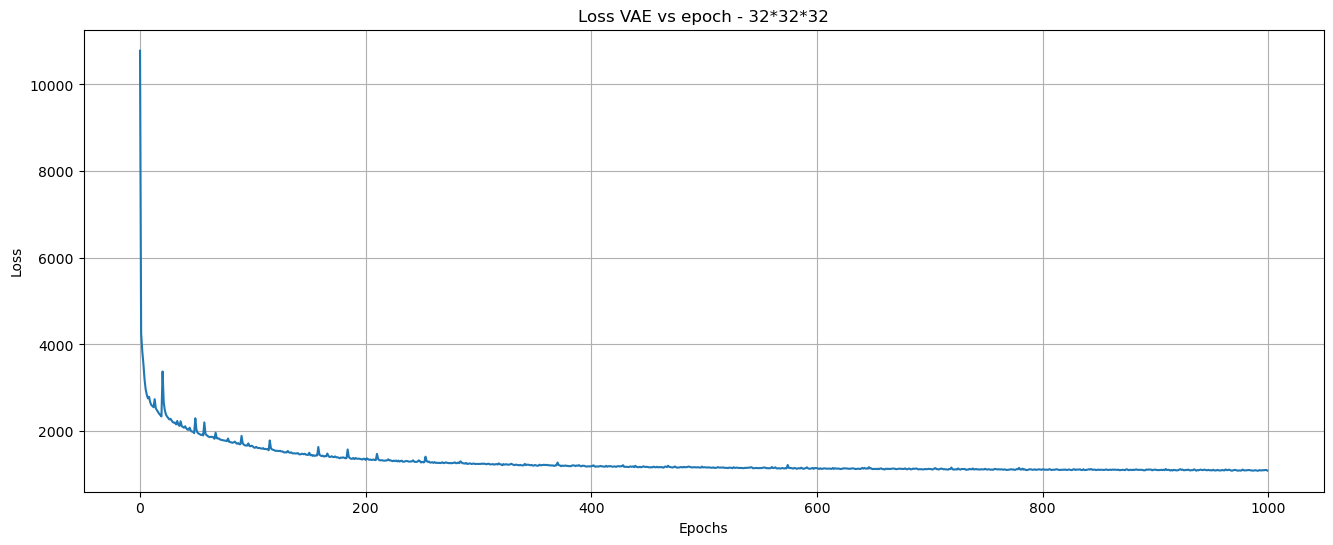

In [51]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(np.array(losses))
ax.set_title(f"Loss VAE vs epoch - {NX}*{NY}*{NZ}")
ax.set_xlabel(f"Epochs")
ax.set_ylabel(f"Loss")
ax.grid(True)
plt.show()

In [52]:
# sauve modèles

model_savepath = '/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/models/'
torch.save(encoder, model_savepath+'encoder_mn40_latent128_data32_1000.pth')
torch.save(decoder, model_savepath+'decoder_mn40_latent128_data32_1000.pth')

### Visualize latent space

In [53]:
batch_size = 512

In [54]:
# get the first n_batches in the dataset
n_batches = 5

mn10_converted_loader = DataLoader(
    modelnet10_converted,
    batch_size=batch_size,
    shuffle=True
)

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

# set dataloader ... same as training :-)
data_iter = iter(mn40_converted_loader)

# form latent space
latent_tensor = torch.zeros((batch_size, latent_dim * 2))
all_labels = torch.zeros((batch_size))

# encode the first n_batches
for bn in range(n_batches):
    batch_ps, batch_label = next(data_iter)
    batch_ps = batch_ps.to(device)
    with torch.no_grad():
        encoded_batch = encoder(batch_ps)
        if bn==0:
            latent_tensor = encoded_batch
            all_labels = batch_label
        else:
            latent_tensor = torch.concatenate([latent_tensor, encoded_batch], axis=0)
            all_labels = torch.concatenate([all_labels, batch_label], axis=0)

Explained variance = [0.02991282 0.02768379 0.02483743]


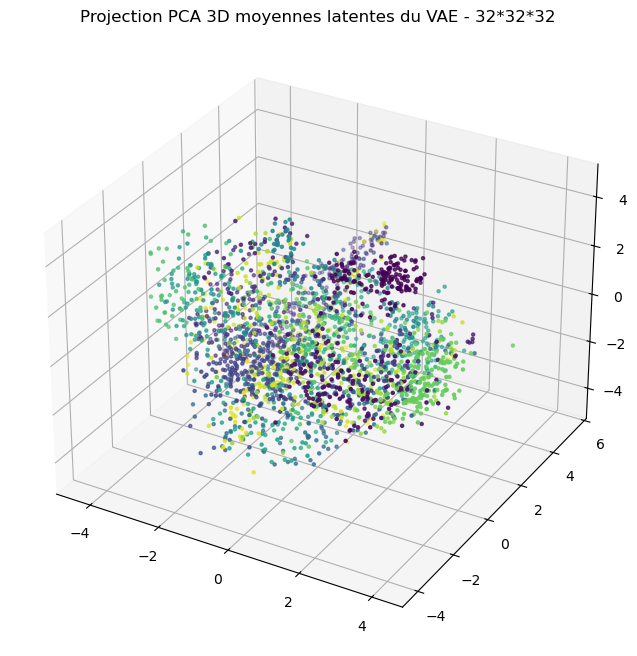

In [55]:
# get data
X = latent_tensor[:,:latent_dim].cpu().numpy()  # get mu's of the Gaussians
l = all_labels.numpy().reshape(-1,)

# form PCA
pca = PCA(n_components=3)
X_3D = pca.fit_transform(X)
print(f"Explained variance = {pca.explained_variance_ratio_}")

# # display
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
ax.scatter(X_3D[:,0], X_3D[:,1], X_3D[:,2], marker='.', c=l)
ax.set_title(f"Projection PCA 3D moyennes latentes du VAE - {NX}*{NY}*{NZ}")
ax.grid(True)
plt.show()

In [56]:
df = pd.DataFrame(data=X_3D, columns=['X','Y','Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.2, symbol_sequence=['circle'], title=f"{PCA}", color=l)
fig.show()

### XPs - First step : we visually check the ability of the trained VAE to generate point clouds

In [57]:
batch_size = 1

mn40_converted_loader = DataLoader(
    modelnet40_converted,
    batch_size=batch_size,
    shuffle=True
)

data_iter = iter(mn40_converted_loader)

ground_truth, batch_label = next(data_iter)

Ground truth point cloud

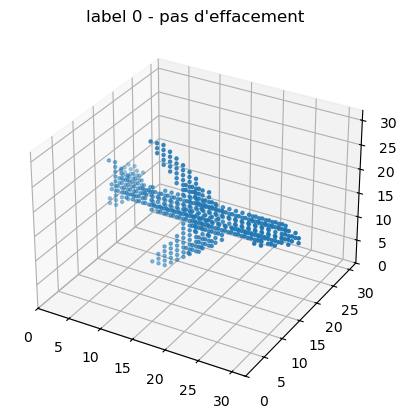

In [58]:
fig = display_3d_tensor(ground_truth[0,:], name=f"label {batch_label.item()} - pas d'effacement")

Sampling generated point clouds from the posterior distribution of the latent variable

In [59]:
# encodage
encoded_batch = encoder(ground_truth.to(device))
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
# print(f"posterior z|x = {q_zgivenx}")

# sampling K posterior samples
K = 5
z_sample_reparametrized = q_zgivenx.rsample((K,))
# print(f"z_samples_reparametrized samplés = {z_sample_reparametrized.shape}")

# observation model
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
    reinterpreted_batch_ndims=3
)
# print(f"observation models x|z = {p_xgivenz}")

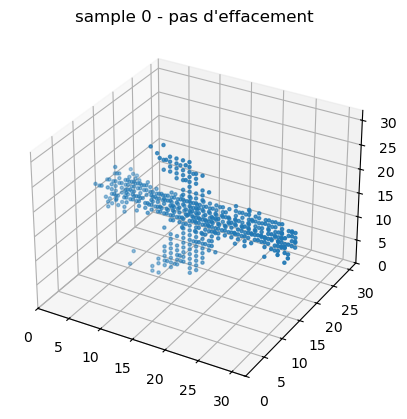

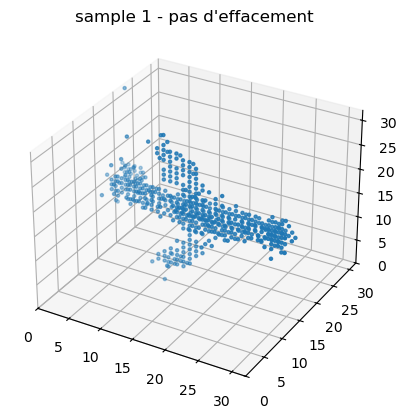

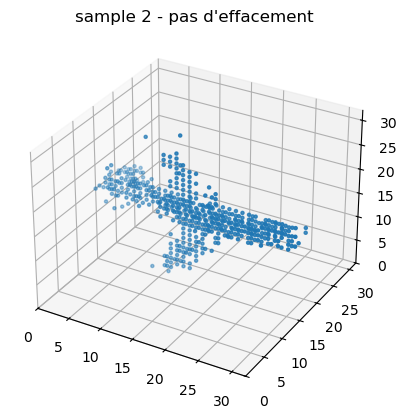

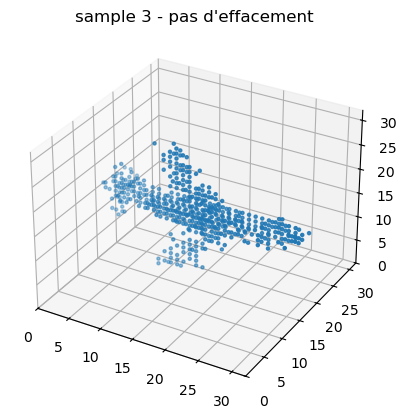

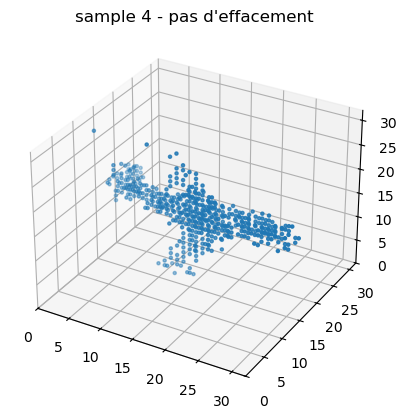

In [60]:
# display observation samples
xs = p_xgivenz.sample()

for i in range(K):
    sample = xs[i,0]
    fig = display_3d_tensor(sample, name=f"sample {i} - pas d'effacement")

### XPs - now we remove some points in the ground truth point cloud, and visually inspect the generation by the VAE

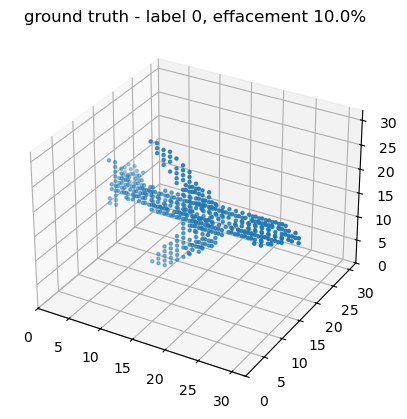

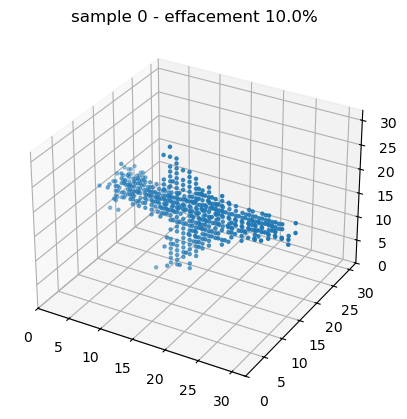

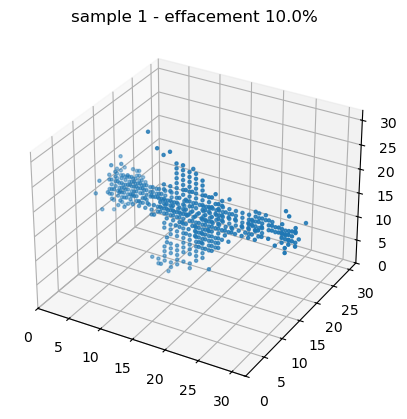

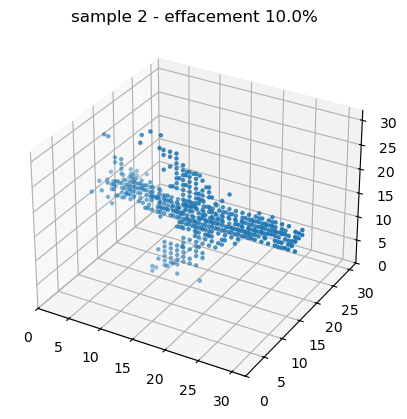

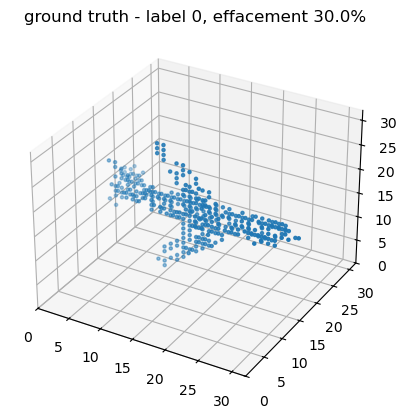

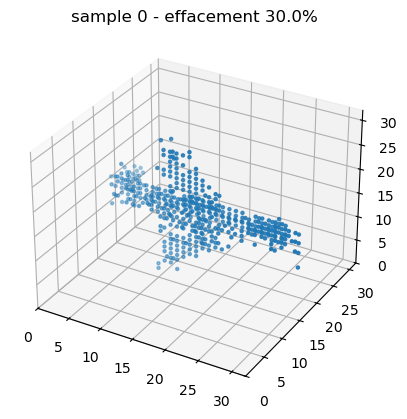

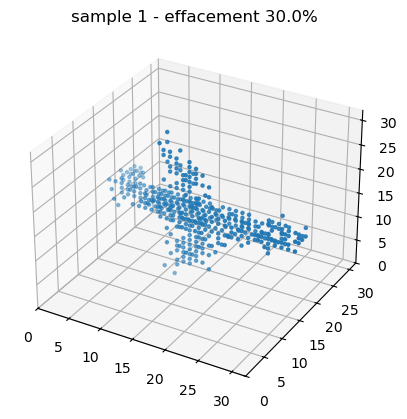

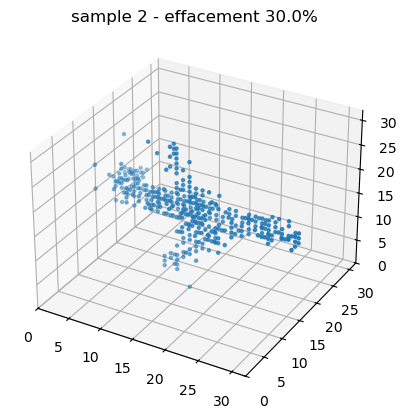

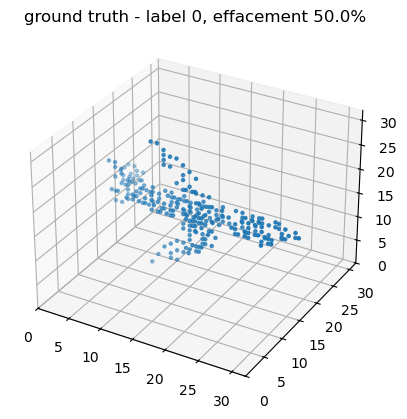

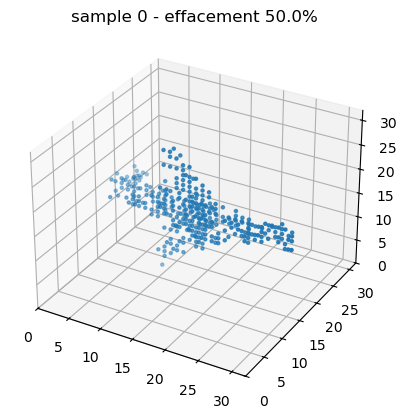

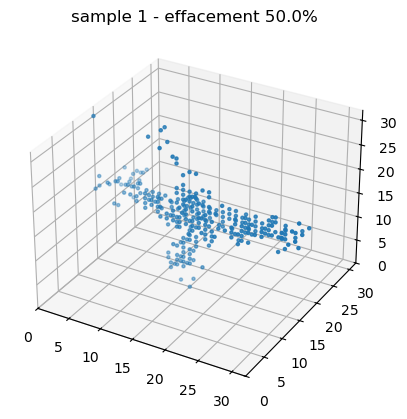

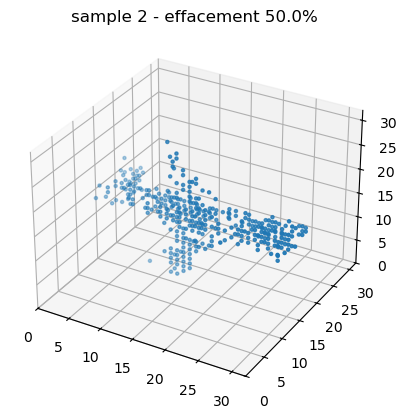

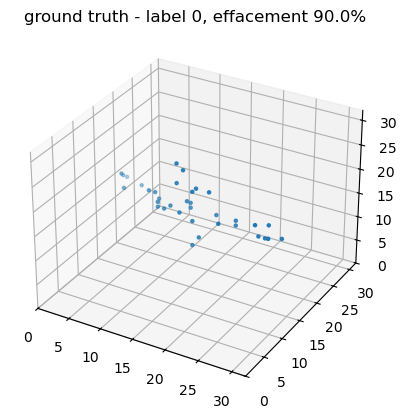

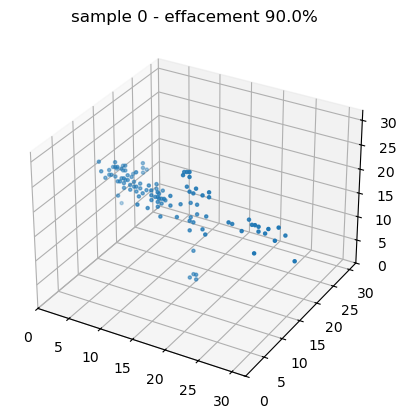

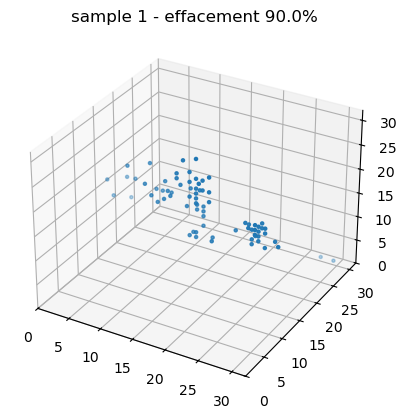

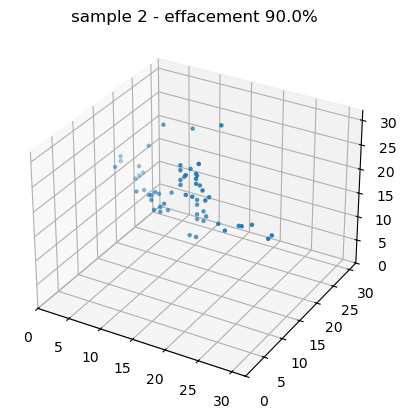

In [61]:
size = (NX,NY,NZ)

#
# here we define the proportion of points that we will remove from the ground truth point cloud
#
list_ratios = [0.1, 0.3, 0.5, 0.9]

K = 3 # number of observation samples

for ratio in list_ratios:
    
    # compute mask with x % of 0's
    mask = torch.randint(low=0, high=100, size=size)  # random integers between 0 and 99
    mask = torch.where(mask < ratio*100, 0 ,1)
    # take out random points in the original ground truth points cloud
    masked_ground_truth = ground_truth.to(device) * mask.to(device)
    fig = display_3d_tensor(masked_ground_truth[0,:], name=f"ground truth - label {batch_label.item()}, effacement {ratio*100}%")
    
    # encode masked ground truth
    encoded_masked_gt = encoder(masked_ground_truth.to(device))
    mu_q = encoded_masked_gt[:,:latent_dim]
    sigma_q = nn.Softplus()(encoded_masked_gt[:,latent_dim:])
    # compute posterior given masked ground truth
    q_zgivenx = td.Independent(
        td.Normal(loc=mu_q, scale=sigma_q),
        reinterpreted_batch_ndims=1
    )
    # sampling K posterior samples
    z_sample_reparametrized = q_zgivenx.rsample((K,))
    # form the observation model
    p_xgivenz = td.Independent(
        td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
        reinterpreted_batch_ndims=3
    )
    
    # generate and display observation samples
    xs = p_xgivenz.sample()
    for i in range(K):
        sample = xs[i,0]
        fig = display_3d_tensor(sample, name=f"sample {i} - effacement {ratio*100}%")

### We see that the VAE has somehow learnt the number of points of the ground truth point cloud, and therefore does not seem appropriate as such for scene completion